# Ingeniería de características (Feature Engineering)

Antes de adentrarnos en tipos de datos más complejos, como texto o imágenes, empecemos por el más simple: los datos numéricos. Dado que los datos numéricos ya están en un formato fácilmente digerible por los modelos matemáticos, podría parecer que se requiere poco trabajo. Sin embargo, la ingeniería de características sigue siendo esencial. Unas características efectivas no solo capturan los rasgos clave de los datos, sino que también se alinean con las suposiciones del modelo. Esto a menudo exige transformar los datos numéricos en bruto. Dominar estas técnicas básicas es crucial, ya que constituyen la base de la ingeniería de características en todos los tipos de datos.

La primera comprobación con datos numéricos consiste en evaluar si la **magnitud** de los valores es importante. ¿Necesitas conocer la magnitud exacta o basta con distinguir entre valores positivos y negativos? A veces, una granularidad gruesa es suficiente. Esto es especialmente cierto para recuentos generados automáticamente, como las visitas diarias a un sitio web o el número de reseñas de un restaurante.

A continuación, considera la **escala** de las características. ¿Cuáles son los valores mínimo y máximo? ¿Varían en un rango amplio o incluso en varios órdenes de magnitud? Esto es crucial porque muchos modelos son sensibles a la escala de la entrada. Por ejemplo, en una función lineal simple como $3x + 1$, la salida escala directamente con la entrada. Métodos como *k*-means, vecinos más cercanos y cualquier algoritmo que dependa de la distancia euclidiana son muy dependientes de la escala de las características. En estos casos, es buena práctica normalizar los datos para que la salida del modelo se mantenga dentro de un rango predecible.

Por otro lado, algunos modelos, como los que implican funciones lógicas, no se ven afectados por la escala de las características. Las funciones lógicas, como la operación AND, producen salidas binarias independientemente de la magnitud de las entradas. Del mismo modo, los árboles de decisión, que se construyen a partir de funciones escalón de las características de entrada, no requieren normalización. No obstante, existe una salvedad: si una característica numérica es un recuento acumulado que crece con el tiempo, puede terminar superando el rango con el que se entrenó el árbol. En ese caso, puede ser necesario un reescalado periódico de las entradas para mantener el rendimiento del modelo.

Otro aspecto crítico a considerar es la **distribución** de las características numéricas. La distribución define la probabilidad de que una característica tome ciertos valores y puede afectar de distintas maneras a diferentes modelos. Por ejemplo, los modelos de regresión lineal suponen que los errores de predicción se distribuyen de forma normal (gaussiana). Esta suposición suele cumplirse salvo que la variable objetivo abarque varios órdenes de magnitud. En tales casos, la hipótesis de error gaussiano puede dejar de aplicarse, y transformar la variable objetivo puede ayudar a normalizar la distribución. Un enfoque común es aplicar una transformación logarítmica, que es un tipo de **transformación de potencia** que aproxima la distribución a una gaussiana.

Comprender estos elementos clave —magnitud, escala y distribución— te ayudará a diseñar características que mejoren el rendimiento y la capacidad de generalización del modelo.



## Manejo de recuentos (*counts*)

En la era del *Big Data*, los recuentos aparecen por todas partes: número de visitas, clics, compras, genes expresados, etc. Sin embargo, trabajar con recuentos plantea desafíos: suelen ser **asimétricos**, pueden abarcar **varios órdenes de magnitud** y con frecuencia contienen **valores atípicos**. Decidir cómo transformar estos recuentos puede tener un impacto significativo en la estabilidad del entrenamiento y en la calidad de las predicciones.

En esta sección veremos estrategias como **discretización (*binning*)** y **transformaciones logarítmicas**, útiles para estabilizar la varianza y mitigar la influencia de valores extremos.


### Cuantización o *Binning*

Supongamos que nuestra tarea es usar recuentos para predecir un resultado. Una opción es **agrupar** los valores en intervalos (*bins*) y utilizar el índice del intervalo como característica. Esto puede reducir la sensibilidad a pequeñas fluctuaciones y hacer que el modelo sea más **robusto**. Existen enfoques de **anchura fija** (intervalos iguales) y enfoques **adaptativos** (intervalos basados en percentiles), cada uno con sus ventajas.


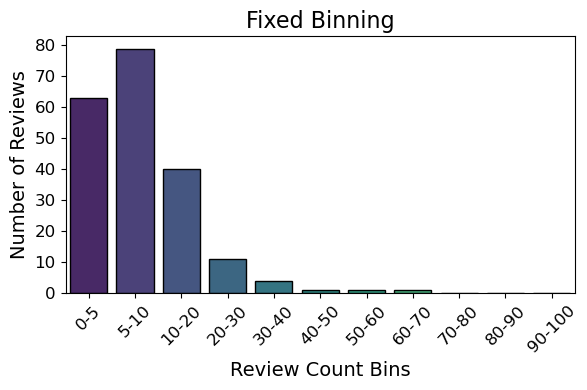

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Generate skewed synthetic review counts using a log-normal distribution
np.random.seed(42)
review_counts = np.random.lognormal(mean=2, sigma=0.8, size=200).astype(int)

# Define fixed bin edges
bin_edges = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = [f"{bin_edges[i]}-{bin_edges[i+1]}" for i in range(len(bin_edges)-1)]

# Digitize the review counts into bins
binned_counts = np.digitize(review_counts, bins=bin_edges)

# Count occurrences in each bin
binned_data = np.zeros(len(bin_labels), dtype=int)
for i in range(1, len(bin_edges)):
    binned_data[i-1] = np.sum(binned_counts == i)

# Create a DataFrame for plotting
binned_df = pd.DataFrame({'Bin': bin_labels, 'Count': binned_data})

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x='Bin', y='Count', data=binned_df, palette='viridis', edgecolor='black')
plt.title('Fixed Binning', fontsize=16)
plt.xlabel('Review Count Bins', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()


#### *Binning* de anchura fija
Con *binning* de anchura fija, cada intervalo cubre el mismo rango numérico. Este método es sencillo y reproducible, pero puede ser ineficiente si la distribución es muy asimétrica.

#### *Binning* por percentiles (cuantílico)
El *binning* por percentiles divide los datos de modo que **cada intervalo contenga un número similar de observaciones**. Esto ayuda cuando la distribución está muy sesgada o contiene valores atípicos. Por ejemplo, los cuartiles dividen en cuatro partes y los deciles en diez.


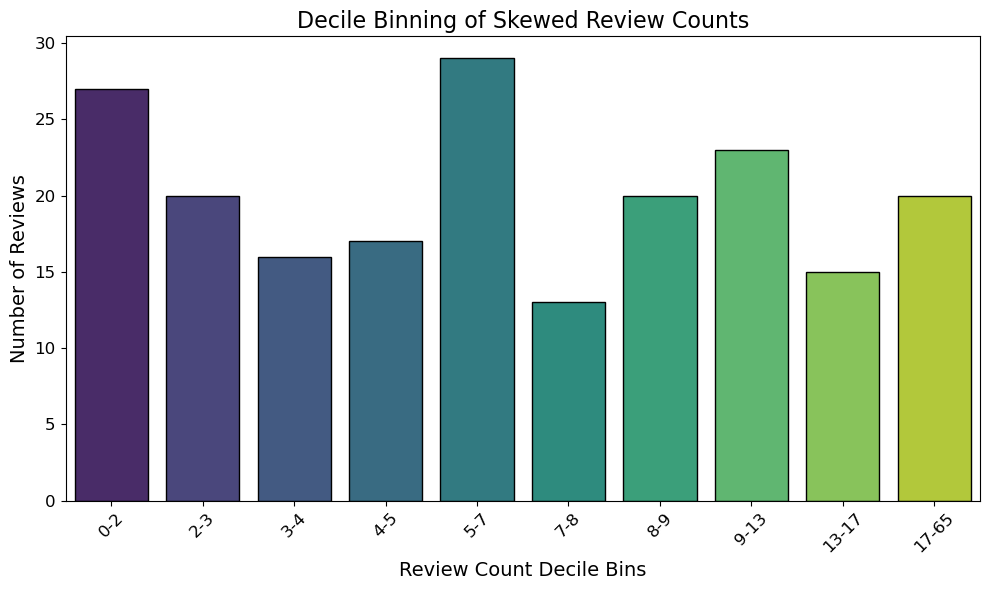

In [4]:
# Define deciles for binning
deciles = np.percentile(review_counts, np.arange(0, 101, 10))
bin_labels = [f"{int(deciles[i])}-{int(deciles[i+1])}" for i in range(len(deciles)-1)]

# Digitize the review counts into decile bins
binned_counts = pd.cut(review_counts, bins=deciles, labels=bin_labels, include_lowest=True)

# Count occurrences in each decile bin
binned_data = binned_counts.value_counts().sort_index()

# Create a DataFrame for plotting
binned_df = pd.DataFrame({'Bin': binned_data.index, 'Count': binned_data.values})

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Bin', y='Count', data=binned_df, palette='viridis', edgecolor='black')
plt.title('Decile Binning of Skewed Review Counts', fontsize=16)
plt.xlabel('Review Count Decile Bins', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()


### Transformación logarítmica

Otra técnica potente para tratar recuentos (y valores positivos en general) es aplicar la **transformación logarítmica** (p. ej., `log(1 + x)`). Esto **reduce la asimetría**, comprime los valores grandes y tiende a estabilizar la varianza, creando un rango más manejable para el modelo.


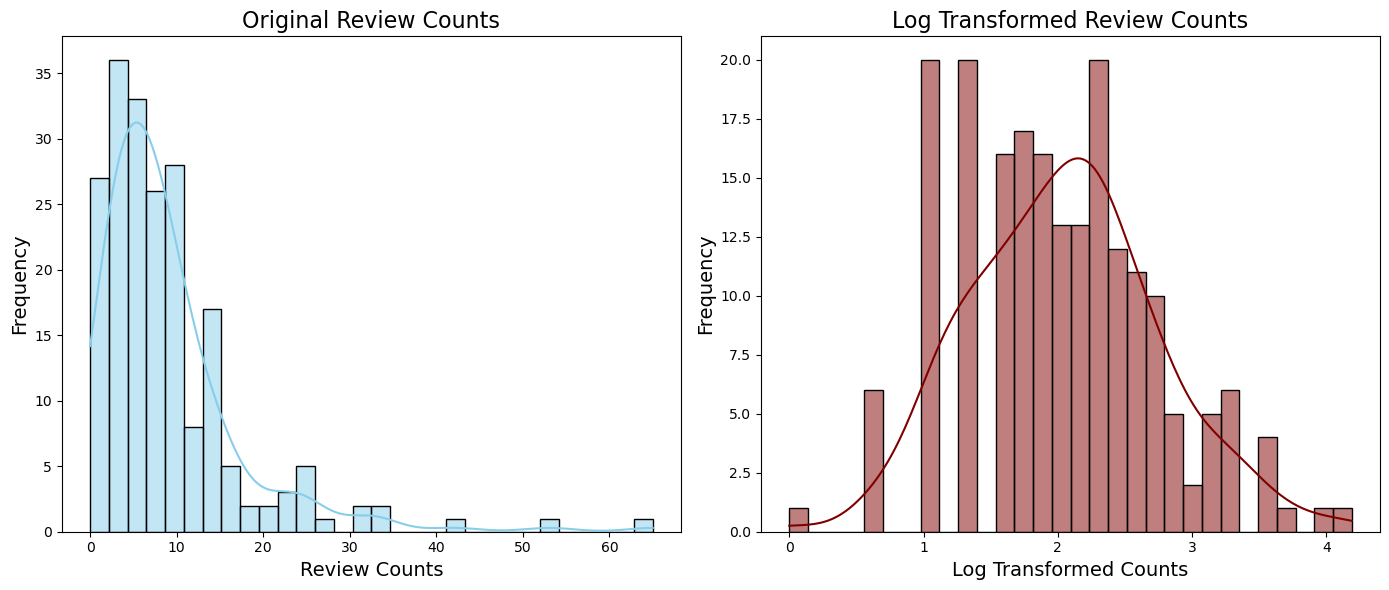

In [5]:
# Apply log transformation (adding 1 to avoid log(0))
log_transformed_counts = np.log1p(review_counts)

# Create DataFrames for original and log-transformed data
original_df = pd.DataFrame({'Review Counts': review_counts})
log_df = pd.DataFrame({'Log Transformed Counts': log_transformed_counts})

# Plotting the original and log-transformed data side by side
plt.figure(figsize=(14, 6))

# Original Data Plot
plt.subplot(1, 2, 1)
sns.histplot(original_df['Review Counts'], bins=30, color='skyblue', kde=True)
plt.title('Original Review Counts', fontsize=16)
plt.xlabel('Review Counts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Log Transformed Data Plot
plt.subplot(1, 2, 2)
sns.histplot(log_df['Log Transformed Counts'], bins=30, color='maroon', kde=True)
plt.title('Log Transformed Review Counts', fontsize=16)
plt.xlabel('Log Transformed Counts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()


Observa que la distribución parece mucho más **gaussiana** después de aplicar la transformación logarítmica.


Aplicando estos métodos —ya sea *binning* o la transformación log— podemos **suavizar la variabilidad**, reducir el efecto de valores extremos y proporcionar al modelo entradas más estables, lo que a menudo conduce a **mejores predicciones**.


### Transformaciones de potencia: generalización de la transformación logarítmica

La **transformación logarítmica** es un caso específico de una familia más amplia de transformaciones conocidas como **transformaciones de potencia**. Estas transformaciones se utilizan en estadística para **estabilizar la varianza**, es decir, ajustar la distribución de una variable de modo que su varianza deje de depender de su media.

Una generalización clave tanto de la raíz cuadrada como del logaritmo es la **transformación de Box–Cox**, definida como:

$$
X^{(\lambda)} = \left\{
\begin{array}{l}
\frac{X^{\lambda} - 1}{\lambda} \ \text{si} \ \lambda \neq 0, \\[10pt]
\log(X) \ \text{si} \ \lambda = 0.
\end{array}
\right.
$$

En esta ecuación, $X$ es la variable original y $\lambda$ es el **parámetro de potencia** que controla la forma de la transformación. La fórmula está construida de manera que cuando $\lambda = 0$, se reduce a la **transformación logarítmica**, $\log(X)$. Para otros valores de $\lambda$, aplica una transformación de potencia a los datos. La transformación de Box–Cox es continua cuando $\lambda$ se aproxima a cero y garantiza que los valores transformados sean **monótonos**, es decir, que se preserve el orden de los datos tras la transformación.

Transformaciones de potencia destacadas:

1. **Transformación de raíz cuadrada ($\lambda = 0.5$)**: útil para estabilizar la varianza cuando la variable consiste en recuentos positivos o valores que crecen de forma cuadrática. Puede ayudar a reducir la asimetría hacia la derecha.

2. **Transformación logarítmica ($\lambda = 0$)**: se aplica habitualmente a datos con crecimiento exponencial o que abarcan varios órdenes de magnitud. Comprime los valores grandes y expande los pequeños, facilitando el modelado.

3. **Transformación inversa ($\lambda = -1$)**: a veces se emplea cuando los valores grandes de una variable son menos significativos que los pequeños, otorgando efectivamente mayor peso a los números pequeños.

El parámetro de potencia $\lambda$ es crucial para determinar el comportamiento de la transformación. Puede estimarse mediante técnicas gráficas, que ayudan a visualizar cómo afecta la transformación a la distribución, permitiendo elegir un $\lambda$ que minimice la asimetría o haga los datos más simétricos. Alternativamente, puede estimarse de forma más rigurosa mediante el **método de máxima verosimilitud**, que identifica la transformación que mejor ajusta los datos a una distribución normal.

Las transformaciones de potencia, incluida la de Box–Cox, son muy útiles cuando se trabaja con datos sesgados o cuando es necesario hacer que la distribución de una variable sea más simétrica y parecida a la normal, lo que puede mejorar el rendimiento de muchos modelos estadísticos. Sin embargo, no están exentas de limitaciones. Por ejemplo, la transformación de Box–Cox solo funciona con datos estrictamente positivos, aunque esto puede solventarse desplazando los datos para que todos los valores sean positivos. Aunque transformaciones más simples como el logaritmo o la raíz cuadrada son fáciles de interpretar, valores arbitrarios de $\lambda$ en Box–Cox pueden resultar más difíciles de interpretar, complicando el trabajo con los datos transformados. Además, un uso excesivo de transformaciones, especialmente en modelos complejos, puede conducir al **sobreajuste**, haciendo que el modelo se ajuste demasiado a los datos transformados y reduzca su capacidad de generalización a datos nuevos.


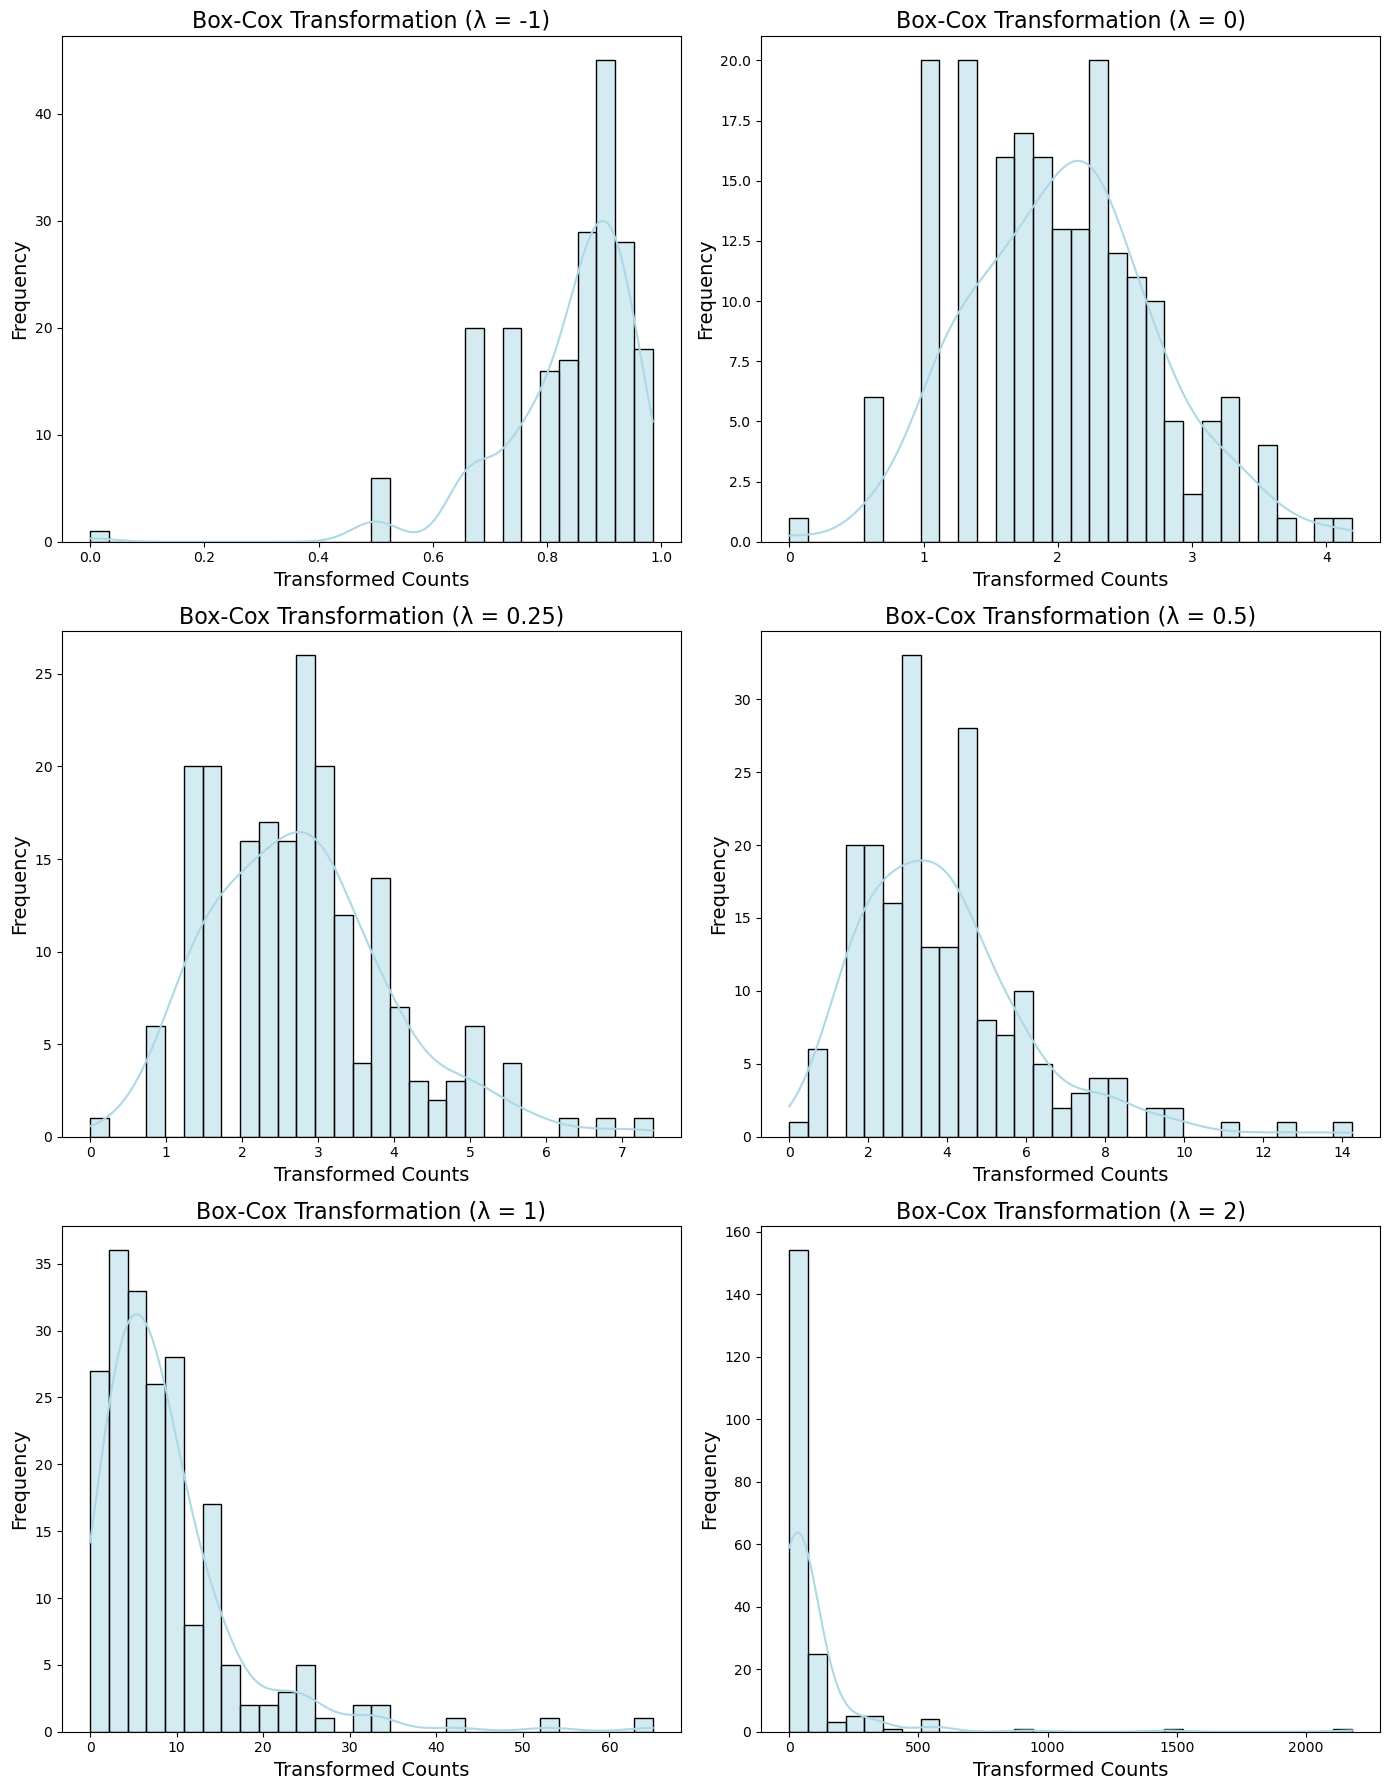

In [6]:
from scipy import stats

# Define lambda values for Box-Cox transformation
lambda_values = [-1, 0, 0.25, 0.5, 1, 2]
transformed_data = []

# Apply Box-Cox transformation for each lambda
for lam in lambda_values:
    if lam == 0:
        # Use log transformation for lambda = 0
        transformed_data.append(np.log1p(review_counts))
    else:
        transformed_data.append(stats.boxcox(review_counts + 1, lmbda=lam))  # Adding 1 to avoid issues with zero values

# Create DataFrame for transformed data
transformed_df = pd.DataFrame(transformed_data).T
transformed_df.columns = [f'Lambda = {lam}' for lam in lambda_values]

# Create a grid for plotting
fig, axs = plt.subplots(3, 2, figsize=(14, 18))

# Plot transformed data distributions
for i, lam in enumerate(lambda_values):
    ax = axs[i // 2, i % 2]
    sns.histplot(transformed_df[f'Lambda = {lam}'], bins=30, kde=True, color='lightblue', ax=ax)
    ax.set_title(f'Box-Cox Transformation (λ = {lam})', fontsize=16)
    ax.set_xlabel('Transformed Counts', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()


## Escalado y normalización de características

El escalado de características es un paso crucial cuando los algoritmos son **sensibles a la magnitud** de las entradas (p. ej., regresión ridge/lasso, k-NN, SVM, redes neuronales). Las dos técnicas más comunes son:

- **Estandarización (z-score)**: restar la media y dividir por la desviación estándar, para obtener media 0 y varianza 1.
- **Escalado *min–max***: llevar cada característica a un rango fijo, típicamente [0, 1].

Para distribuciones con **valores atípicos** pronunciados, resulta útil el **escalado robusto** (mediana y rango intercuartílico), ya que los valores extremos pueden distorsionar el escalado clásico.


### Escalado min–max

El escalado min–max transforma las características a un rango fijo, normalmente entre 0 y 1.
Sea $x$ un valor individual de una característica (es decir, el valor de la característica en algún dato), y sean $\min(x)$ y $\max(x)$, respectivamente, el mínimo y el máximo de esa característica en todo el conjunto de datos.

$$
\tilde x  = \frac{x - \min(x)}{\max(x) - \min(x)}
$$

Esto es especialmente útil para algoritmos como *k*-vecinos más cercanos (KNN) y *k*-means, que dependen de métricas de distancia. Sin embargo, es sensible a valores atípicos, ya que los extremos pueden distorsionar el escalado.


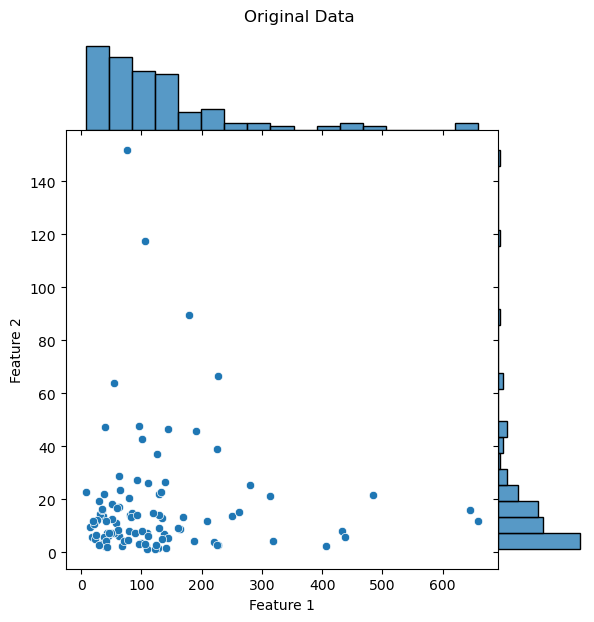

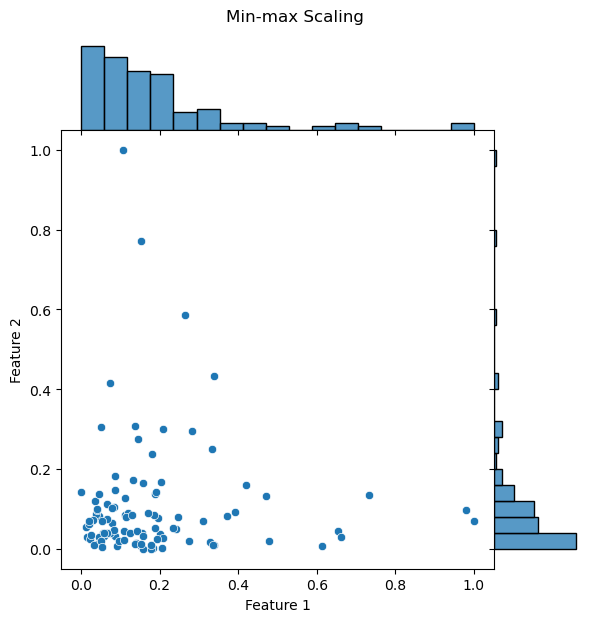

In [7]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data (100 points)
np.random.seed(42)
data = np.random.lognormal(mean=0, sigma=1, size=(100, 2)) * [[100, 10]]  # Feature 1 in [0, 10000], Feature 2 in [0, 100]

def plot_with_histograms(df, title):
    g = sns.JointGrid(data=df, x='Feature 1', y='Feature 2', space=0)
    g.plot(sns.scatterplot, sns.histplot)
    g.fig.suptitle(title, y=1.03)
    plt.show()

# Apply Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create DataFrames to store the original and scaled data
df_original = pd.DataFrame(data, columns=['Feature 1', 'Feature 2'])
df_scaled = pd.DataFrame(scaled_data, columns=['Feature 1', 'Feature 2'])

plot_with_histograms(df_original, 'Original Data')
plot_with_histograms(df_scaled, 'Min-max Scaling')



### Estandarización (*z-score*) y *min–max*

El **min–max** conserva la forma de la distribución pero la reescala a un intervalo definido (p. ej., [0, 1]).
La **estandarización** centra cada variable y la escala por su desviación estándar, haciendo que características con unidades distintas sean comparables. 

$$
\tilde x  = \frac{x - \bar x}{\hat \sigma_x}
$$

**¿Cuándo usar cuál?**
- Usa **estandarización** cuando el algoritmo asume datos centrados y con varianza comparable.
- Usa **min–max** cuando quieres preservar la **distribución relativa** y acotas el rango por requisitos del modelo (p. ej., activaciones sigmoides).


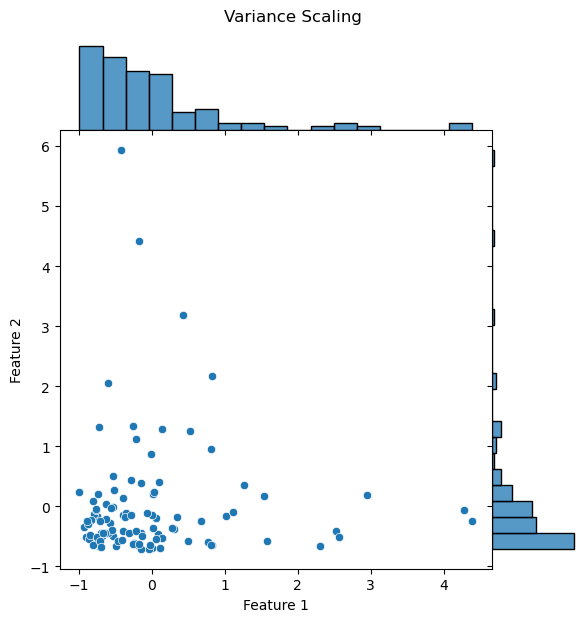

In [8]:
from sklearn.preprocessing import StandardScaler

# Apply Standardization
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

# Create DataFrames to store the standardized data
df_standardized = pd.DataFrame(standardized_data, columns=['Feature 1', 'Feature 2'])

plot_with_histograms(df_standardized, 'Variance Scaling')

```{warning}
DON’T “CENTER” SPARSE DATA!

Use caution when performing min-max scaling and standardization on sparse features. Both subtract a quantity from the original feature value. 
If the shift is not zero, then these two transforms can turn a sparse feature vector where most values are zero into a dense one. This in turn could create a huge computational burden for the classifier, depending on how it is implemented.
```

### Normalización L2

La normalización L2 divide cada vector de características por su norma \$L\_2\$, también conocida como norma euclidiana, de modo que los vectores resultantes tengan longitud 1. Esta norma mide la longitud del vector en el espacio de coordenadas y se define así:

$$
\tilde x = \frac{x}{||x||_2}
$$

donde

$$
||x||_2 =  \sqrt{x^2_1 + x^2_2 + \dots + x^2_m}
$$

Es especialmente útil en modelos como SVM o KNN, donde la **dirección** de los vectores es más importante que su **magnitud**. La normalización L2 preserva las distancias relativas entre puntos y asegura que ninguna característica individual domine debido a su escala.


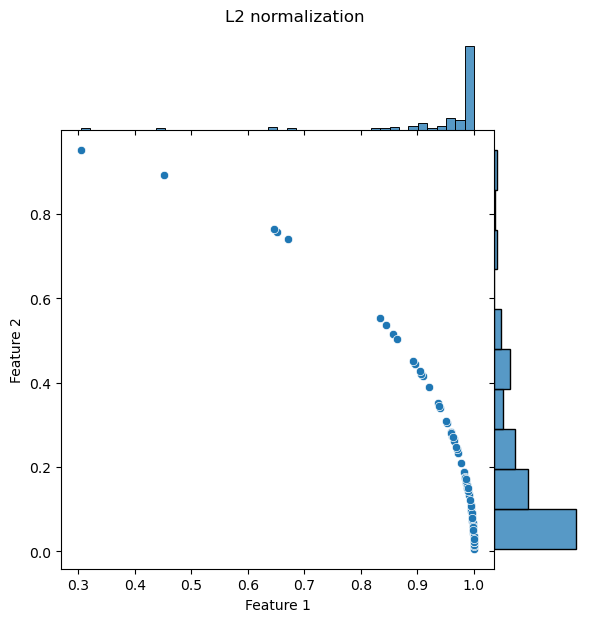

In [9]:
from sklearn.preprocessing import Normalizer

# Apply L2 Normalization
normalizer = Normalizer(norm='l2')
normalized_data = normalizer.fit_transform(data)

# Create DataFrames to store the standardized data
df_normalized = pd.DataFrame(normalized_data, columns=['Feature 1', 'Feature 2'])

plot_with_histograms(df_normalized, 'L2 normalization')

## Selección de características

Las técnicas de selección de características eliminan las que no son útiles para reducir la complejidad del modelo resultante.

> Dado un conjunto de $d$ características, seleccionar un subconjunto de tamaño $m$ que produzca el menor error de clasificación.

El objetivo final es un modelo parsimonioso que se compute más rápido, con poca o ninguna degradación en la precisión predictiva. Para llegar a un modelo así, algunas técnicas de selección requieren entrenar más de un modelo candidato. En otras palabras, la selección de características no trata de reducir el tiempo de **entrenamiento** —de hecho, algunas técnicas aumentan el tiempo total de entrenamiento—, sino de reducir el tiempo de **inferencia** (evaluación) del modelo.

Una vez fijado $m$ (regla empírica: $N_{class}/m > 10$), elige las $m$ características más informativas manteniendo:

* Grandes distancias entre clases
* Pequeñas distancias intra-clase



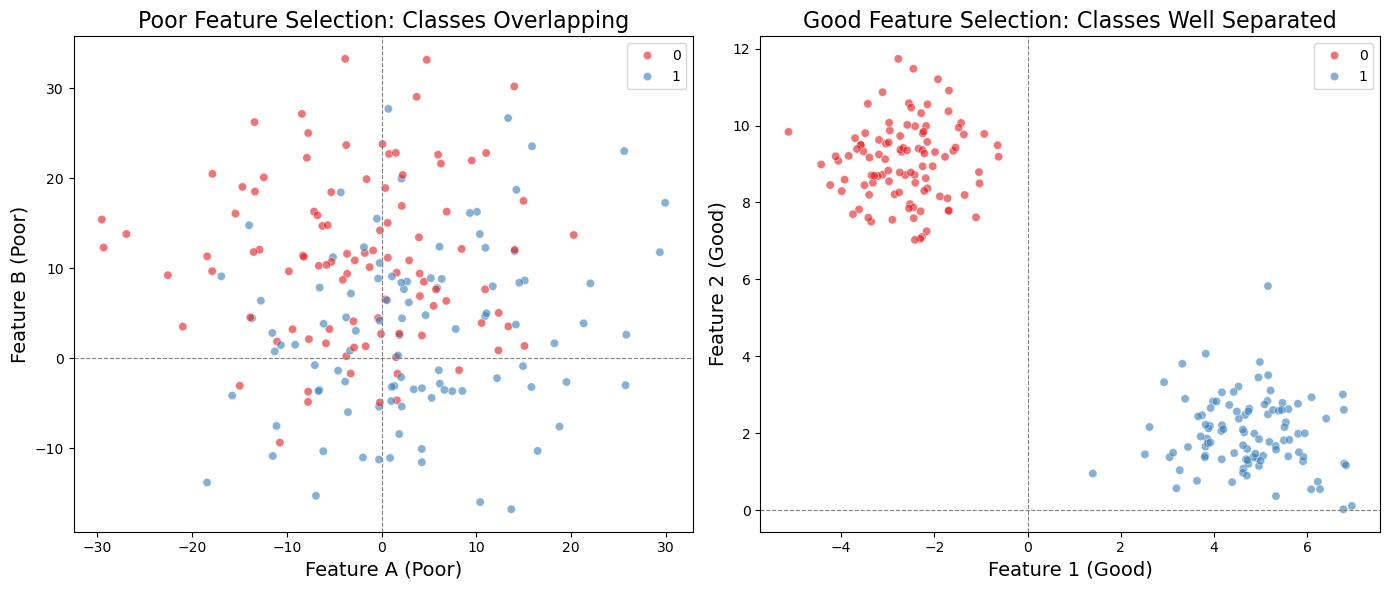

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs

# Set random seed for reproducibility
np.random.seed(42)

# Create synthetic data with two classes
n_samples = 200
X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=1.0)  # Reduced std for better separation

# Poor feature selection case: mixing the features
# Adding a noise feature that doesn't help in classification
X_poor = np.column_stack((X[:, 0] + np.random.normal(0, 10, n_samples), 
                           X[:, 1] + np.random.normal(0, 10, n_samples)))

# Good feature selection case: using the original features
X_good = X

# Plotting
plt.figure(figsize=(14, 6))

# Poor Feature Selection
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_poor[:, 0], y=X_poor[:, 1], hue=y, palette='Set1', alpha=0.6)
plt.title('Poor Feature Selection: Classes Overlapping', fontsize=16)
plt.xlabel('Feature A (Poor)', fontsize=14)
plt.ylabel('Feature B (Poor)', fontsize=14)
plt.axhline(0, color='grey', lw=0.8, ls='--')
plt.axvline(0, color='grey', lw=0.8, ls='--')

# Good Feature Selection
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_good[:, 0], y=X_good[:, 1], hue=y, palette='Set1', alpha=0.6)
plt.title('Good Feature Selection: Classes Well Separated', fontsize=16)
plt.xlabel('Feature 1 (Good)', fontsize=14)
plt.ylabel('Feature 2 (Good)', fontsize=14)
plt.axhline(0, color='grey', lw=0.8, ls='--')
plt.axvline(0, color='grey', lw=0.8, ls='--')

plt.tight_layout()
plt.show()


Las técnicas de selección de características pueden clasificarse, a grandes rasgos, en cuatro clases principales:

### Filtrado

Los métodos de filtrado evalúan la relevancia de las características en función de sus propiedades intrínsecas, de forma independiente de cualquier modelo concreto. Suelen emplear medidas estadísticas para valorar la relación entre cada característica y la variable objetivo. Métodos habituales:

* **Coeficientes de correlación**: evaluar la correlación entre cada característica y el objetivo. Las características con baja correlación pueden descartarse.
* **Prueba ji-cuadrado (Chi-Squared)**: valorar la independencia entre características categóricas y el objetivo, ayudando a seleccionar las que muestran mayor asociación con la salida.
* **Ganancia de información (Information Gain)**: medir la reducción de incertidumbre sobre el objetivo dada la característica. Una mayor ganancia de información indica una característica más informativa.

Los métodos de filtrado suelen ser rápidos y eficientes, por lo que son adecuados para conjuntos de datos de alta dimensionalidad. Sin embargo, pueden pasar por alto **interacciones** entre características que resulten importantes para la predicción.

### Métodos no supervisados

Las técnicas no supervisadas no dependen de datos etiquetados; se centran en encontrar patrones o estructuras en los propios datos. Métodos comunes:

* **Análisis de Componentes Principales (PCA)**: técnica de reducción de dimensionalidad que transforma las características originales en un nuevo conjunto de variables no correlacionadas (componentes principales) que capturan la máxima varianza. Permite seleccionar los componentes más informativos.
* **t-Distributed Stochastic Neighbor Embedding (t-SNE)**: usada principalmente para visualización; puede ayudar a identificar clústeres en datos de alta dimensión y orientar la selección de las características que más contribuyen a la separación de dichos clústeres.

Los métodos no supervisados son valiosos cuando escasean las etiquetas, pero pueden no corresponderse directamente con la variable objetivo.

### Métodos *wrapper* (envolventes)

Evalúan subconjuntos de características entrenando y probando un modelo sobre ellos, usando el rendimiento del modelo para determinar las mejores características. Incluyen:

* **Selección hacia adelante (Forward Selection)**: parte sin características y va añadiendo la que más mejora el rendimiento hasta que no hay mejora adicional.
* **Eliminación hacia atrás (Backward Elimination)**: parte con todas las características y elimina, una a una, la que menos afecta al rendimiento hasta que no se puede mejorar más.
* **Eliminación recursiva de características (RFE)**: elimina iterativamente las características menos importantes según coeficientes del modelo o importancias hasta retener un número especificado.

Aunque a menudo proporcionan subconjuntos mejor adaptados a un modelo concreto, son **computacionalmente costosos**, especialmente con datos grandes.

### Métodos embebidos (*embedded*)

Integran la selección de características en el propio proceso de entrenamiento del modelo. Suelen ser más eficientes que los *wrapper* e incluyen:

* **Regresión Lasso**: regresión lineal con penalización L1, que reduce a cero algunos coeficientes y, por tanto, selecciona las características que más contribuyen a la predicción.
* **Métodos basados en árboles**: algoritmos como Random Forest y Gradient Boosting proporcionan puntuaciones de importancia en función de la frecuencia con que una característica se usa en divisiones a lo largo de los árboles, permitiendo seleccionar de forma natural las más significativas.

Los métodos embebidos logran un equilibrio entre filtrado y *wrapper*, y a menudo producen subconjuntos de alta calidad con un coste computacional menor.


---

## Ejemplo de código: conjunto de datos *Mobile Price*

1. Los datos ya están ordenados (*tidy*) y particionados en archivos CSV de entrenamiento y prueba.
2. Hay 2000 observaciones en el conjunto de entrenamiento y 1000 en el de prueba.
3. Cada observación consiste en 20 características del teléfono (columnas) y una etiqueta categórica (columna final) que describe el rango de precio del teléfono.

### Descripción de los datos

| Característica | Descripción                                                                                         |
| -------------- | --------------------------------------------------------------------------------------------------- |
| battery\_power | Energía total que una batería puede almacenar en un momento, medida en mAh                          |
| blue           | Tiene Bluetooth o no                                                                                |
| clock\_speed   | Velocidad a la que el microprocesador ejecuta instrucciones                                         |
| dual\_sim      | Tiene doble SIM o no                                                                                |
| fc             | Megapíxeles de la cámara frontal                                                                    |
| four\_g        | Tiene 4G o no                                                                                       |
| int\_memory    | Memoria interna en gigabytes                                                                        |
| m\_dep         | Grosor del móvil en cm                                                                              |
| mobile\_wt     | Peso del teléfono móvil                                                                             |
| n\_cores       | Número de núcleos del procesador                                                                    |
| pc             | Megapíxeles de la cámara principal                                                                  |
| px\_height     | Altura de la resolución en píxeles                                                                  |
| px\_width      | Anchura de la resolución en píxeles                                                                 |
| ram            | Memoria de acceso aleatorio (RAM) en megabytes                                                      |
| sc\_h          | Altura de la pantalla del móvil en cm                                                               |
| sc\_w          | Anchura de la pantalla del móvil en cm                                                              |
| talk\_time     | Tiempo máximo que dura una única carga de batería                                                   |
| three\_g       | Tiene 3G o no                                                                                       |
| touch\_screen  | Tiene pantalla táctil o no                                                                          |
| wifi           | Tiene wifi o no                                                                                     |
| price\_range   | Variable objetivo con valores 0 (bajo coste), 1 (coste medio), 2 (alto coste) y 3 (muy alto coste). |



### Configuración

Organicemos todos los requisitos antes de pasar al ejercicio. Por ahora, no te preocupes demasiado por los modelos que utilizaremos ni por cómo entrenarlos.


In [11]:
# Globals
seed = 1017

#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tableone import TableOne
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

#magic
%matplotlib inline

Para demostrar la utilidad de la selección de características, compararemos la **capacidad predictiva** de un modelo **con** y **sin** selección de características. Así, por cada modelo parsimonioso que entrenemos, comparemos su rendimiento con el de su **modelo completo** equivalente (es decir, el que utiliza **todas** las características).


### Carga de los datos

Deberíamos observar cómo se distribuyen las características agrupadas por las etiquetas. Para ello, generaremos una **TableOne**.


In [12]:
# load the data as a pandas dataframe
df = pd.read_csv("datasets/ch02_data/train.csv")
df_test = pd.read_csv("datasets/ch02_data/test.csv")

# Generate table 1
TableOne(df, groupby=df.columns[-1],
         pval=True,
         dip_test=True,
         normal_test=True,
         tukey_test=True)

Grouped by price_range                                                                                         
                                          Missing          Overall               0               1               2               3 P-Value
n                                                             2000             500             500             500             500        
battery_power, mean (SD)                        0   1238.5 (439.4)  1116.9 (410.8)  1228.9 (438.6)  1228.3 (452.9)  1380.0 (415.0)  <0.001
blue, n (%)              0                             1010 (50.5)      257 (51.4)      255 (51.0)      257 (51.4)      241 (48.2)   0.698
                         1                              990 (49.5)      243 (48.6)      245 (49.0)      243 (48.6)      259 (51.8)        
clock_speed, mean (SD)                          0        1.5 (0.8)       1.6 (0.8)       1.5 (0.8)       1.5 (0.8)       1.5 (0.8)   0.687
dual_sim, n (%)          0                              981 (49.0)      250 (50.0)      245 (49.0)      251 (50.2)      235 (47.0)   0.732
                         1                             1019 (50.9)      250 (50.0)      255 (51.0)      249 (49.8)      265 (53.0)        
fc, mean (SD)                                   0        4.3 (4.3)       4.1 (4.2)       4.3 (4.5)       4.5 (4.3)       4.3 (4.3)   0.510
four_g, n (%)            0                              957 (47.9)      241 (48.2)      238 (47.6)      253 (50.6)      225 (45.0)   0.365
                         1                             1043 (52.1)      259 (51.8)      262 (52.4)      247 (49.4)      275 (55.0)        
int_memory, mean (SD)                           0      32.0 (18.1)     31.2 (18.1)     32.1 (18.0)     30.9 (18.4)     34.0 (17.9)   0.033
m_dep, mean (SD)                                0        0.5 (0.3)       0.5 (0.3)       0.5 (0.3)       0.5 (0.3)       0.5 (0.3)   0.212
mobile_wt, mean (SD)                            0     140.2 (35.4)    140.6 (36.4)    140.5 (35.7)    143.6 (34.3)    136.3 (34.9)   0.013
n_cores, n (%)           1                              242 (12.1)        49 (9.8)       76 (15.2)       52 (10.4)       65 (13.0)   0.488
                         2                              247 (12.3)       69 (13.8)       59 (11.8)       57 (11.4)       62 (12.4)        
                         3                              246 (12.3)       62 (12.4)       69 (13.8)       56 (11.2)       59 (11.8)        
                         4                              274 (13.7)       67 (13.4)       76 (15.2)       73 (14.6)       58 (11.6)        
                         5                              246 (12.3)       59 (11.8)       51 (10.2)       66 (13.2)       70 (14.0)        
                         6                              230 (11.5)       61 (12.2)       54 (10.8)       57 (11.4)       58 (11.6)        
                         7                              259 (13.0)       66 (13.2)       55 (11.0)       69 (13.8)       69 (13.8)        
                         8                              256 (12.8)       67 (13.4)       60 (12.0)       70 (14.0)       59 (11.8)        
pc, mean (SD)                                   0        9.9 (6.1)       9.6 (6.1)       9.9 (6.1)      10.0 (6.0)      10.2 (6.1)   0.480
px_height, mean (SD)                            0    645.1 (443.8)   536.4 (372.8)   666.9 (441.4)   632.3 (445.8)   744.8 (483.7)  <0.001
px_width, mean (SD)                             0   1251.5 (432.2)  1150.3 (413.0)  1251.9 (433.6)  1234.0 (427.8)  1369.8 (426.8)  <0.001
ram, mean (SD)                                  0  2124.2 (1084.7)   785.3 (362.8)  1679.5 (465.9)  2582.8 (496.2)  3449.2 (393.0)  <0.001
sc_h, mean (SD)                                 0       12.3 (4.2)      12.3 (4.2)      12.2 (4.2)      12.0 (4.2)      12.7 (4.2)   0.083
sc_w, mean (SD)                                 0        5.8 (4.4)       5.7 (4.2)       5.5 (4.2)       5.7 (4.3)       6.1 (4.7)   0.

## Comparación de modelos

Definamos una función que calcule el rendimiento del **modelo completo** y del **modelo parsimonioso**.


In [13]:
#define function that compares selected features to full model
def compare_models(dataset, selfeat):
    """compare parsimonious and full linear model"""
    
    # get predictors and labels
    X = dataset.drop('price_range',axis=1)  #independent columns
    y = dataset['price_range']    #target column i.e price range

    #get selected feature indecies
    isel = [X.columns.get_loc(feat) for feat in selfeat if feat in X]
    
    #70-30 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)
 

    #define the prodigious and parsimonious logistic models
    prodmodel = LinearRegression()
    parsmodel = LinearRegression()

    #Fit the models
    prodmodel.fit(X_train, y_train)
    parsmodel.fit(X_train[selfeat], y_train) 

    #Report errors
    display('Prodigious Model Score: %.3f' %prodmodel.score(X_test, y_test))
    display('Parsimonious Model Score: %.3f' %parsmodel.score(X_test[selfeat], y_test))

    return

### Filtrado

Las técnicas de filtrado preprocesan las características para eliminar aquellas que probablemente no sean útiles para el modelo. Por ejemplo, se puede calcular la correlación o la información mutua entre cada característica y la variable de respuesta, y filtrar las características que queden por debajo de un umbral. Las técnicas de filtrado son mucho más baratas que las técnicas *wrapper* descritas a continuación, pero no tienen en cuenta el modelo que se emplea. Por ello, puede que no seleccionen las características adecuadas para ese modelo. Es preferible realizar el prefiltrado de forma **conservadora**, para no eliminar inadvertidamente características útiles antes siquiera de la fase de entrenamiento.

> La **Tabla 1** ya ha calculado la asociación de cada característica con el resultado. Seleccionemos solo aquellas características que estén significativamente asociadas (p < .05).


In [15]:
selfeat = ['battery_power', 'int_memory', 'mobile_wt', 'px_height', 'px_width', 'ram', 'sc_h']
compare_models(df, selfeat)

'Prodigious Model Score: 0.914'

'Parsimonious Model Score: 0.915'

> Al mantener solo 7 características, el modelo parsimonioso obtiene esencialmente la misma puntuación que el modelo completo que usa las 20 características.


### Métodos no supervisados
**Eliminar características altamente correlacionadas** es un ejemplo de método no supervisado de selección. Otros incluyen **PCA** y **ICA**, que proyectan los datos a espacios de menor dimensión preservando la mayor **varianza** o independencia posible. Una forma práctica de inspeccionar dependencias es un **mapa de calor** de correlaciones.


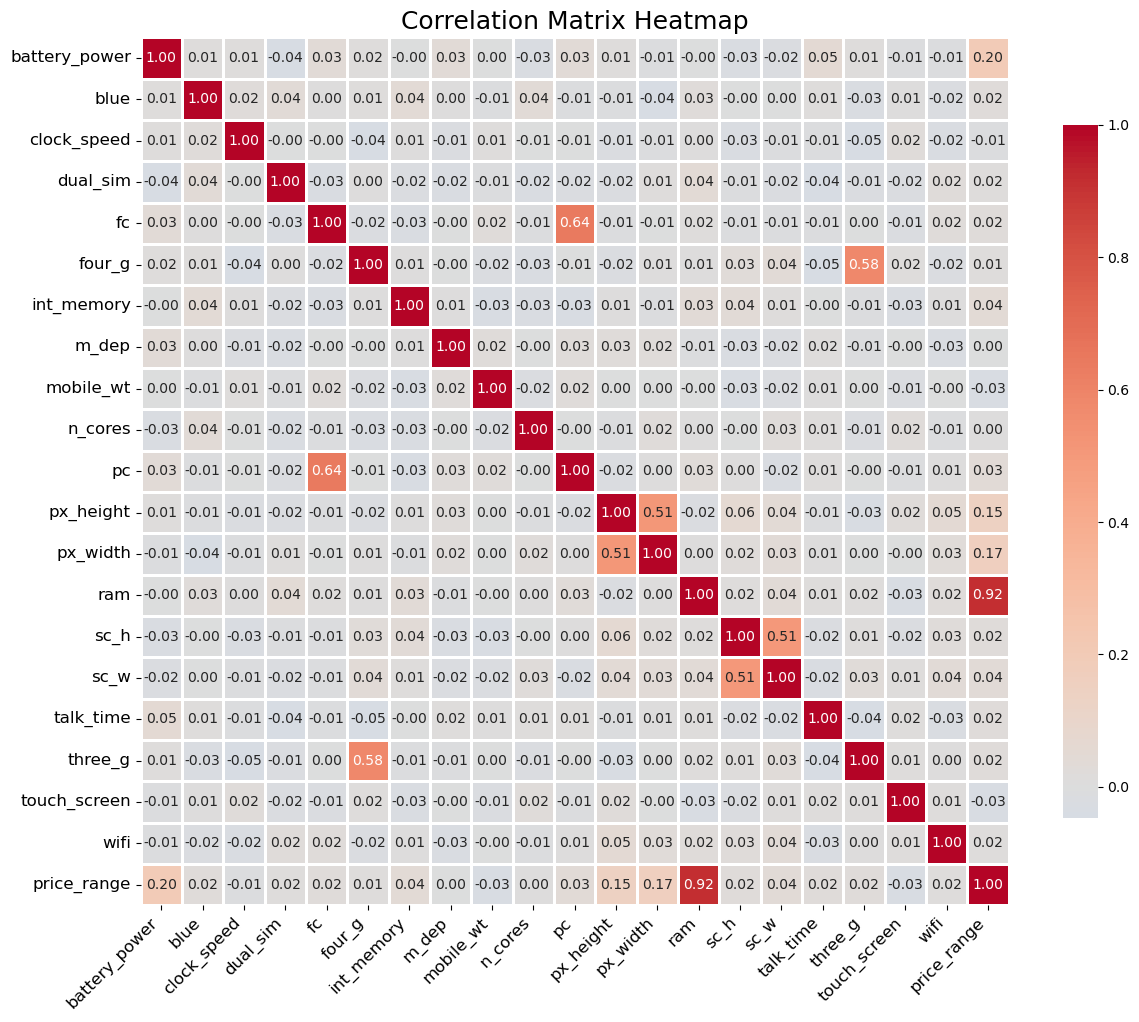

In [16]:
# Create a correlation matrix for the columns in the dataset
correlation_matrix = df.corr()

# Set up the matplotlib figure with improved size and aspect ratio
plt.figure(figsize=(14, 12))

# Use seaborn's heatmap with improved aesthetics
g = sns.heatmap(correlation_matrix, 
                annot=True,          # Annotate cells with correlation coefficients
                fmt=".2f",           # Format the annotations to 2 decimal places
                cmap="coolwarm",      # Use a diverging colormap
                center=0,             # Set the midpoint of the colormap at 0
                square=True,          # Make each cell square-shaped
                linewidths=1,         # Add gridlines between cells
                linecolor='white',    # Gridline color
                cbar_kws={'shrink': 0.75},  # Shrink the color bar for better fitting
                annot_kws={"size": 10})    # Annotation text size

# Improve title and labels for clarity
plt.title("Correlation Matrix Heatmap", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and align the x-tick labels
plt.yticks(rotation=0, fontsize=12)  # Keep y-tick labels horizontal

# Add tight layout for better spacing
# plt.tight_layout()

# Display the plot
plt.show()


Podemos **iterar** sobre la matriz de correlación y marcar como redundantes las variables que superen el umbral respecto a alguna ya marcada como relevante. Esto produce un conjunto reducido con menor redundancia y, a menudo, modelos **más estables**.


In [17]:
#init an empty set that will contain the names of the correlated features
correlated_features = set()

#loop over lower triangle of pairs of features
#     do not consider the last feature which is the label 
for i in range(len(correlation_matrix .columns) - 1):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            #accumulate the names of the second correlated feature
            colname = correlation_matrix.columns[j]
            correlated_features.add(colname)

In [18]:
#display the correlated features
display(correlated_features)

{'fc', 'four_g', 'px_height', 'sc_h'}

Estas características están correlacionadas con al menos otra característica por encima del umbral. Probemos a entrenar con el **conjunto parsimonioso** y ver cómo afecta al rendimiento del modelo en comparación con el conjunto completo.


In [19]:
#add label to the correlated features which we will drop
correlated_features.add('price_range')
selfeat = df.columns.drop(correlated_features)
compare_models(df, selfeat)

'Prodigious Model Score: 0.914'

'Parsimonious Model Score: 0.904'

> En este caso, el modelo parsimonioso obtiene (bondad de ajuste) **menor** que el modelo completo.


### Métodos *wrapper*

Estos métodos son más **costosos computacionalmente**, pero evalúan **subconjuntos** de características entrenando y validando un modelo predictivo. Ejemplos: **RFE** (*recursive feature elimination*) y búsqueda secuencial hacia delante/atrás. Aquí utilizaremos un modelo basado en **árboles** para RFE.


In [20]:
X = df.drop('price_range', axis=1)
y = df['price_range']

# Use a tree-based model for RFE
rfe = RFECV(estimator=DecisionTreeClassifier(), step=1)

# Fit RFE
rfe.fit(X, y)

# Create a DataFrame to summarize feature selection results
summary_df = pd.DataFrame({
    'Feature': X.columns,
    'Selected': rfe.support_,
    'Rank': rfe.ranking_
})

# Display the results as a table
display(summary_df)



Feature  Selected  Rank
0   battery_power      True     1
1            blue     False    14
2     clock_speed     False     7
3        dual_sim     False    11
4              fc     False    12
5          four_g     False    15
6      int_memory     False     3
7           m_dep     False    10
8       mobile_wt     False     2
9         n_cores     False     5
10             pc     False     9
11      px_height      True     1
12       px_width      True     1
13            ram      True     1
14           sc_h     False     6
15           sc_w     False     4
16      talk_time     False     8
17        three_g     False    13
18   touch_screen     False    16
19           wifi     False    17

Podemos ver qué características han sido seleccionadas mediante sus **índices de columna** o nombres. Después, comparemos el **modelo lineal parsimonioso** con el **modelo completo** para evaluar la diferencia en rendimiento y estabilidad.


In [21]:
#get the column indecies
selcol = [0, 11, 12, 13]
#get the column names
selfeat = df.columns[selcol]
#compare models
compare_models(df, selfeat)

'Prodigious Model Score: 0.914'

'Parsimonious Model Score: 0.914'

### Métodos embebidos (*embedded*)

Estos métodos realizan selección **durante** el entrenamiento del modelo. Ejemplos: **Lasso** (L1), **Elastic Net**, y modelos de **árboles** con importancias. Ofrecen un buen equilibrio entre **coste computacional** y **calidad** de resultados, y además integran la selección en el propio objetivo de entrenamiento.


Model Score: 0.92


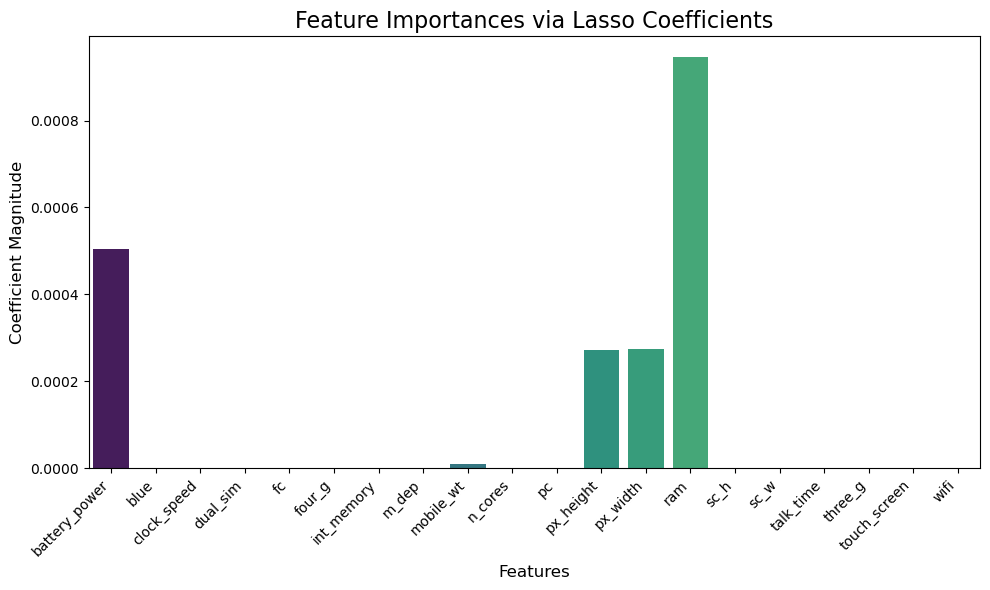

In [22]:
from sklearn.linear_model import LassoCV

# Get predictors and labels
X = np.array(df.drop('price_range', axis=1))
y = np.array(df['price_range'])

# Train Lasso model with 5-fold cross-validation
lasso = LassoCV(cv=5, random_state=0).fit(X, y)

# Display the model score
print(f"Model Score: {lasso.score(X, y):.2f}")

# Get feature importance based on coefficients
importance = np.abs(lasso.coef_)
feature_names = np.array(df.columns.drop('price_range'))

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=importance, palette='viridis')

# Adding labels and title
plt.title("Feature Importances via Lasso Coefficients", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Coefficient Magnitude", fontsize=12)

# Improve the appearance of the x-axis
plt.xticks(rotation=45, ha="right", fontsize=10)

# Tight layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


> De nuevo vemos que **battery_power**, **px_height**, **px_width** y **ram** aparecen como las características más importantes que influyen en el **precio**.
